## Create Dataset

In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import glob
from pyntcloud import PyntCloud
from torch.utils.data import DataLoader
import torch

In [2]:
def load_ply(file_name):
    cloud = PyntCloud.from_file(file_name)
    return cloud.points.values

class PointCloudDataset(Dataset):
    """Point cloud dataset."""

    def __init__(self, number=-1, directory='./data/04379243'):
        
        file_names = sorted(glob.glob('%s/*.ply' % directory))

        if number > 0 and len(file_names) > number:
            file_names = file_names[:number]
        
        point_clouds = []
        for file_name in file_names:

            points = load_ply(file_name)
            point_clouds.append(points)

        self.point_clouds = np.array(point_clouds, dtype='float64')
        self.point_clouds = np.transpose(self.point_clouds, (0, 2, 1))
        
    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx]

In [3]:
point_cloud_dataset = PointCloudDataset(8500)
dataloader = DataLoader(point_cloud_dataset, batch_size=25, shuffle=True)

## Data augmentation

In [4]:
def rotate_point_cloud(batch_data):

    for k in range(batch_data.shape[0]):
        
        # 90, 180, 270 degree
        rotation_angle = int(np.random.uniform() * 4) * np.pi * 0.5

        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        
        rotation_matrix = torch.Tensor([[cosval, -sinval, 0],
                                    [sinval, cosval, 0],
                                    [0, 0, 1]])
        
        shape_pc = batch_data[k, ...].transpose(1, 0)
                
        batch_data[k, ...] = torch.matmul(shape_pc.reshape((-1, 3)), rotation_matrix).transpose(1, 0)
        
    return batch_data

## Model Definition

In [5]:
import torch.nn as nn

In [6]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 128, 1)
        self.conv4 = nn.Conv1d(128, 256, 1)
        self.conv5 = nn.Conv1d(256, 32, 1)
        self.maxPool1d = nn.MaxPool1d(2048)
        
        self.relu = nn.ReLU()
        self.bn1  = nn.BatchNorm1d(64) 
        self.bn2  = nn.BatchNorm1d(128) 
        self.bn3  = nn.BatchNorm1d(128)
        self.bn4  = nn.BatchNorm1d(256) 
        self.bn5  = nn.BatchNorm1d(32)

    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.maxPool1d(x)
        return x


class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(32, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2048*3)

        self.relu = nn.ReLU()
        self.bn1  = nn.BatchNorm1d(256) 
        self.bn2  = nn.BatchNorm1d(256) 
        
    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = x.view(-1, 3, 2048)
        
        return x


class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Loss function & callback

In [7]:
import torch.nn.functional as F
from torch.autograd import Variable
from pdb import set_trace as brk

class ChamferLoss(nn.Module):

    # based on https://github.com/345ishaan/DenseLidarNet/blob/master/code/chamfer_loss.py
    def __init__(self):
        super(ChamferLoss, self).__init__()
        self.use_cuda = torch.cuda.is_available()        

    def forward(self,preds,gts):
        P = self.batch_pairwise_dist(gts, preds)
        mins, _ = torch.min(P, 1)
        loss_1 = torch.sum(mins)
        mins, _ = torch.min(P, 2)
        loss_2 = torch.sum(mins)
        return loss_1 + loss_2


    def batch_pairwise_dist(self,x,y):
        x = x.transpose(2, 1)
        y = y.transpose(2, 1)
        _, num_points_x, _ = x.size()
        _, num_points_y, _ = y.size()
        xx = torch.bmm(x, x.transpose(2,1))
        yy = torch.bmm(y, y.transpose(2,1))
        zz = torch.bmm(x, y.transpose(2,1))
        if self.use_cuda:
            dtype = torch.cuda.LongTensor
        else:
            dtype = torch.LongTensor
        diag_ind_x = torch.arange(0, num_points_x).type(dtype)
        diag_ind_y = torch.arange(0, num_points_y).type(dtype)
        rx = xx[:, diag_ind_x, diag_ind_x].unsqueeze(1).expand_as(zz.transpose(2,1))
        ry = yy[:, diag_ind_y, diag_ind_y].unsqueeze(1).expand_as(zz)
        P = (rx.transpose(2,1) + ry - 2*zz)
        return P

In [8]:
class EarlyStopping():
    """
    Early Stopping to terminate training early under certain conditions
    """

    def __init__(self, min_delta=0, patience=5):
        
        """
        EarlyStopping callback to exit the training loop if training or
        validation loss does not improve by a certain amount for a certain
        number of epochs
        Arguments
        ---------
        min_delta : float
            minimum change in monitored value to qualify as improvement.
            This number should be positive.
        patience : integer
            number of epochs to wait for improvment before terminating.
            the counter be reset after each improvment
        """
        
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.best_loss = 1e-15
        self.stopped_epoch = 0

    def on_train_begin(self):
        self.wait = 0
        self.best_loss = 1e15

    def on_epoch_end(self, epoch, current_loss):

        if current_loss is None:
            pass
        else:
            if (current_loss - self.best_loss) < -self.min_delta:
                self.best_loss = current_loss
                self.wait = 1
            else:
                if self.wait >= self.patience:
                    return True
                self.wait += 1
        
        return False

## Train

In [9]:
from torch.autograd import Variable

model = AutoEncoder()

criterion = ChamferLoss()

early_stopping = EarlyStopping(patience=50)

num_epochs = 1000
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    model = model.cuda()

loss_list = []
for epoch in range(num_epochs):
    
    if epoch == 0:
        early_stopping.on_train_begin()

    running_loss = 0.0
    
    for data in dataloader:

        data = rotate_point_cloud(data.float())
                
        if torch.cuda.is_available():
            data = data.cuda()
            
        train_output = model(data)
        
        loss = criterion(train_output, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.detach() 
    
    loss_list.append(running_loss / data.shape[0])
    
    if early_stopping.on_epoch_end(epoch + 1, running_loss):
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss_list[-1]))
        print('Terminated Training for Early Stopping at Epoch %04i' % (epoch + 1))
        break
        
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss_list[-1]))

epoch [1/1000], loss:2094.9558
epoch [50/1000], loss:567.5038
epoch [100/1000], loss:514.0107
epoch [150/1000], loss:493.0399
epoch [200/1000], loss:473.7842
epoch [250/1000], loss:462.0226
epoch [300/1000], loss:459.8929
epoch [350/1000], loss:448.8714
epoch [400/1000], loss:443.8197
epoch [450/1000], loss:444.4948
epoch [500/1000], loss:440.0609
epoch [535/1000], loss:435.2512
Terminated Training for Early Stopping at Epoch 0535


#### save

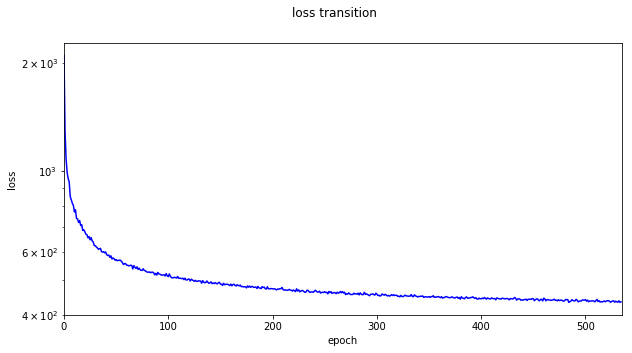

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))        
fig.suptitle('loss transition')
plt.semilogy(loss_list, label="loss", color='b')
plt.xlim([0, epoch + 1])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./models/%.4f.png' % loss_list[-1])
plt.show()

torch.save(model.encoder.state_dict(), './models/encoder_%.4f.pt' % loss_list[-1])
torch.save(model.decoder.state_dict(), './models/decoder_%.4f.pt' % loss_list[-1])

### get input values for validation

In [11]:
train_input  = next(iter(dataloader)).float()
train_input = rotate_point_cloud(train_input.float())

if torch.cuda.is_available():
    train_output = model(train_input.cuda())
    train_output = train_output.cpu()
else:
    train_output = model(train_input)

In [12]:
v_encoder = Encoder()
v_decoder = Decoder()

surfix = loss_list[-1]
v_encoder.load_state_dict(torch.load('./models/encoder_%.4f.pt' % surfix))
v_decoder.load_state_dict(torch.load('./models/decoder_%.4f.pt' % surfix))

## Visual Validation

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

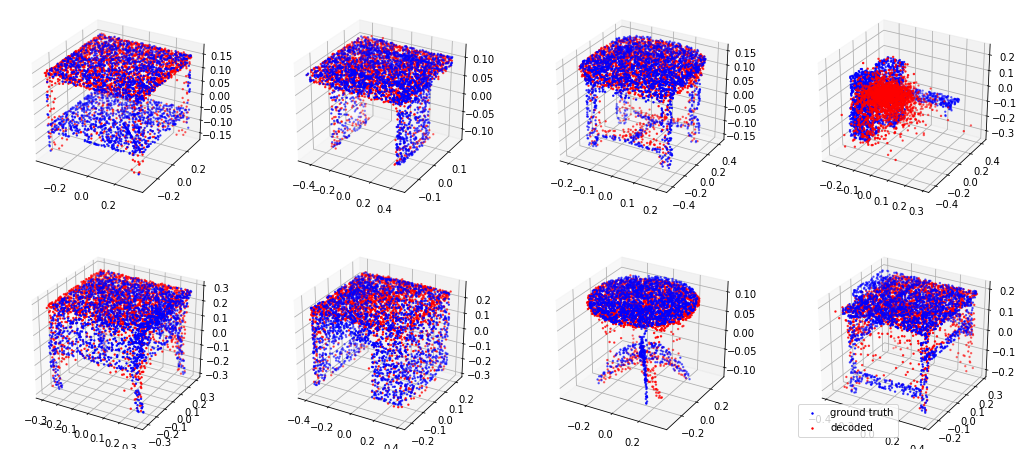

In [14]:
fig = plt.figure(figsize=(18, 8))

for i in range(8):
    
    row, columns, num = 2, 4, i + 1
    ax = fig.add_subplot(row, columns, num, projection='3d')

    data = train_input[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='b', label='ground truth')

    data = train_output[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='r', label='decoded')

ax.legend()
plt.show()

In [15]:
for i in range(8):
    d1 = train_input[i].detach().numpy()
    d2 = train_output[i].detach().numpy()
    print(np.sum(abs(d1 - d2)))

1241.4135
993.0061
1011.71686
896.5574
1219.447
1320.8678
914.72205
1100.6158


In [16]:
for i in range(8):
    d1 = train_input[i]
    d2 = train_output[i]
    print(criterion(d1.reshape(1, 3, 2048), d2.reshape(1, 3, 2048)).data)

tensor(1.4642)
tensor(0.6801)
tensor(0.9149)
tensor(5.8560)
tensor(1.6838)
tensor(1.6714)
tensor(1.4526)
tensor(2.5607)


## Misc

In [17]:
input = torch.randn(10, 2048, 3)
print(input.shape)
m = nn.Conv1d(2048, 256, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(256, 128, 1)
output = m(output)
m = nn.Conv1d(128, 64, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(64, 32, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(3)
output = m(output)
print(output.shape)

torch.Size([10, 2048, 3])
torch.Size([10, 256, 3])
torch.Size([10, 64, 3])
torch.Size([10, 32, 3])
torch.Size([10, 32, 1])


In [18]:
input = torch.randn(10, 3, 2048)
print(input.shape)
m = nn.Conv1d(3, 64, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(64, 128, 1)
output = m(output)
m = nn.Conv1d(128, 256, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(256, 512, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(2048) # output = torch.max(output, 2, keepdim=True)[0]
output = m(output)
print(output.shape)

torch.Size([10, 3, 2048])
torch.Size([10, 64, 2048])
torch.Size([10, 256, 2048])
torch.Size([10, 512, 2048])
torch.Size([10, 512, 1])
